### This code has been adapted in ExactRadialSpectrum.jl

In [2]:
using FourierFlows
using CairoMakie

In [1]:
function get_weights(grid, radius)
    weights = zeros(grid.nkr, grid.nkr)   
    k = grid.kr
    l = (grid.l[1:grid.nkr])'
    l[grid.nkr] = -grid.l[grid.nkr]
    Krsq = k.^2 .+ l.^2
    dk = k[2] - k[1]
    dk_half = dk/2
    
    W_k = k .- dk_half
    E_k = k .+ dk_half
    S_l = l .- dk_half
    N_l = l .+ dk_half
    
    S_l[1] = 0
    N_l[1] = dk_half
    W_k[1] = 0
    E_k[1] = dk_half

    weights[radius^2 .<= (S_l.^2 .+ W_k.^2)] .= 0
    weights[radius^2 .>= (N_l.^2 .+ E_k.^2)] .= 1
    
    clip = (S_l.^2 .+ W_k.^2) .<= radius^2 .<= (N_l.^2 .+ E_k.^2)

    
    upper_octant = (W_k .<= S_l)
    NW_clip = (radius^2 .< N_l.^2 .+ W_k.^2)
    SE_clip = (radius^2 .< S_l.^2 .+ E_k.^2)
    corner_clip = upper_octant .& NW_clip .& SE_clip .& clip
    flat_clip = upper_octant .& NW_clip .& .~SE_clip .& clip
    top_clip = upper_octant .& .~ NW_clip .& .~SE_clip .& clip

    set_corner_clip_weights(weights, corner_clip, W_k, E_k, S_l, N_l, radius)
      set_flat_clip_weights(weights,   flat_clip, W_k, E_k, S_l, N_l, radius)
      set_top_clip_weights(weights,     top_clip, W_k, E_k, S_l, N_l, radius)

    return weights
end

function set_corner_clip_weights(weights, corner_clips, W_k, E_k, S_l, N_l, radius)
    W_ks = W_k[getindex.(findall(corner_clips), 1)]
    E_ks = E_k[getindex.(findall(corner_clips), 1)]
    S_ls = S_l[getindex.(findall(corner_clips), 2)]
    N_ls = N_l[getindex.(findall(corner_clips), 2)]
    W_intersection = @. sqrt(radius^2 - W_ks^2)
    S_intersection = @. sqrt(radius^2 - S_ls^2)
    
    triangle_area = @. 0.5 * (S_intersection - W_ks) * (W_intersection - S_ls)

    chord_length = @. sqrt((S_intersection - W_ks)^2 + (W_intersection - S_ls)^2)
    theta = @. 2 * asin(chord_length / 2 / radius)
    circle_area = @. radius^2 / 2 * (theta - sin(theta))

    area = triangle_area + circle_area
    weight = @. area / ((E_ks - W_ks) * (N_ls - S_ls))
    weights[corner_clips] = weight
    weights'[corner_clips] = weight
end

function set_flat_clip_weights(weights, flat_clips, W_k, E_k, S_l, N_l, radius)
    W_ks = W_k[getindex.(findall(flat_clips), 1)]
    E_ks = E_k[getindex.(findall(flat_clips), 1)]
    S_ls = S_l[getindex.(findall(flat_clips), 2)]
    N_ls = N_l[getindex.(findall(flat_clips), 2)]
    W_intersection = @. sqrt(radius^2 - W_ks^2)
    E_intersection = @. sqrt(radius^2 - E_ks^2)

    rectangle_area = @. (E_ks - W_ks) * (E_intersection - S_ls)
    
    triangle_area = @. 0.5 * (E_ks - W_ks) * (W_intersection - E_intersection)

    chord_length = @. sqrt((E_ks - W_ks)^2 + (W_intersection - E_intersection)^2)
    theta = @. 2 * asin(chord_length / 2 / radius)
    circle_area = @. radius^2 / 2 * (theta - sin(theta))
    
    area = rectangle_area + triangle_area + circle_area
    weight = @. area / ((E_ks - W_ks) * (N_ls - S_ls))
    weights[flat_clips] = weight
    weights'[flat_clips] = weight
end

function set_top_clip_weights(weights, top_clips, W_k, E_k, S_l, N_l, radius)
    W_ks = W_k[getindex.(findall(top_clips), 1)]
    E_ks = E_k[getindex.(findall(top_clips), 1)]
    S_ls = S_l[getindex.(findall(top_clips), 2)]
    N_ls = N_l[getindex.(findall(top_clips), 2)]
    N_intersection = @. sqrt(radius^2 - N_ls^2)
    E_intersection = @. sqrt(radius^2 - E_ks^2)

    W_rectangle_area = @. (N_intersection - W_ks) * (N_ls - S_ls)
    S_rectangle_area = @. (E_ks - N_intersection) * (E_intersection - S_ls)
    
    triangle_area = @. 0.5 * (E_ks - N_intersection) * (N_ls - E_intersection)

    chord_length = @. sqrt((E_ks - N_intersection)^2 + (N_ls - E_intersection)^2)
    theta = @. 2 * asin(chord_length / 2 / radius)
    circle_area = @. radius^2 / 2 * (theta - sin(theta))
    
    area = W_rectangle_area + S_rectangle_area + triangle_area + circle_area
    weight = @. area / ((E_ks - W_ks) * (N_ls - S_ls))
    weights[top_clips] = weight
    weights'[top_clips] = weight
end

function get_approximate_weights(grid, radius)
    weights = ones(grid.nkr, grid.nkr)   
    k = grid.kr
    l = (grid.l[1:grid.nkr])'
    l[grid.nkr] = -grid.l[grid.nkr]
    Krsq = k.^2 .+ l.^2
    dk_half = (k[2] - k[1])/2
    
    ll_corner = (k .- dk_half).^2 .+ (l .- dk_half).^2
    ll_corner[1,:] = (l .- dk_half).^2
    ll_corner[:,1] = (k .- dk_half).^2
    ll_corner[1,1] = 0
    
    ur_corner = (k .+ dk_half).^2 .+ (l .+ dk_half).^2
    ur_corner[1,:] = (l .+ dk_half).^2 .+ dk_half^2
    ur_corner[:,1] = (k .+ dk_half).^2 .+ dk_half^2
    ur_corner[1,1] = 2*dk_half^2
    weights[radius^2 .<= ll_corner] .= 0
    weights[radius^2 .>= ur_corner] .= 1
    mask = ll_corner .< radius^2 .< ur_corner
    weights[mask] .= 1 .- (sqrt.(ur_corner[mask]) .- radius) ./ (sqrt.(ur_corner[mask]) .- sqrt.(ll_corner[mask]))
    return weights
end

get_approximate_weights (generic function with 1 method)

(33,)


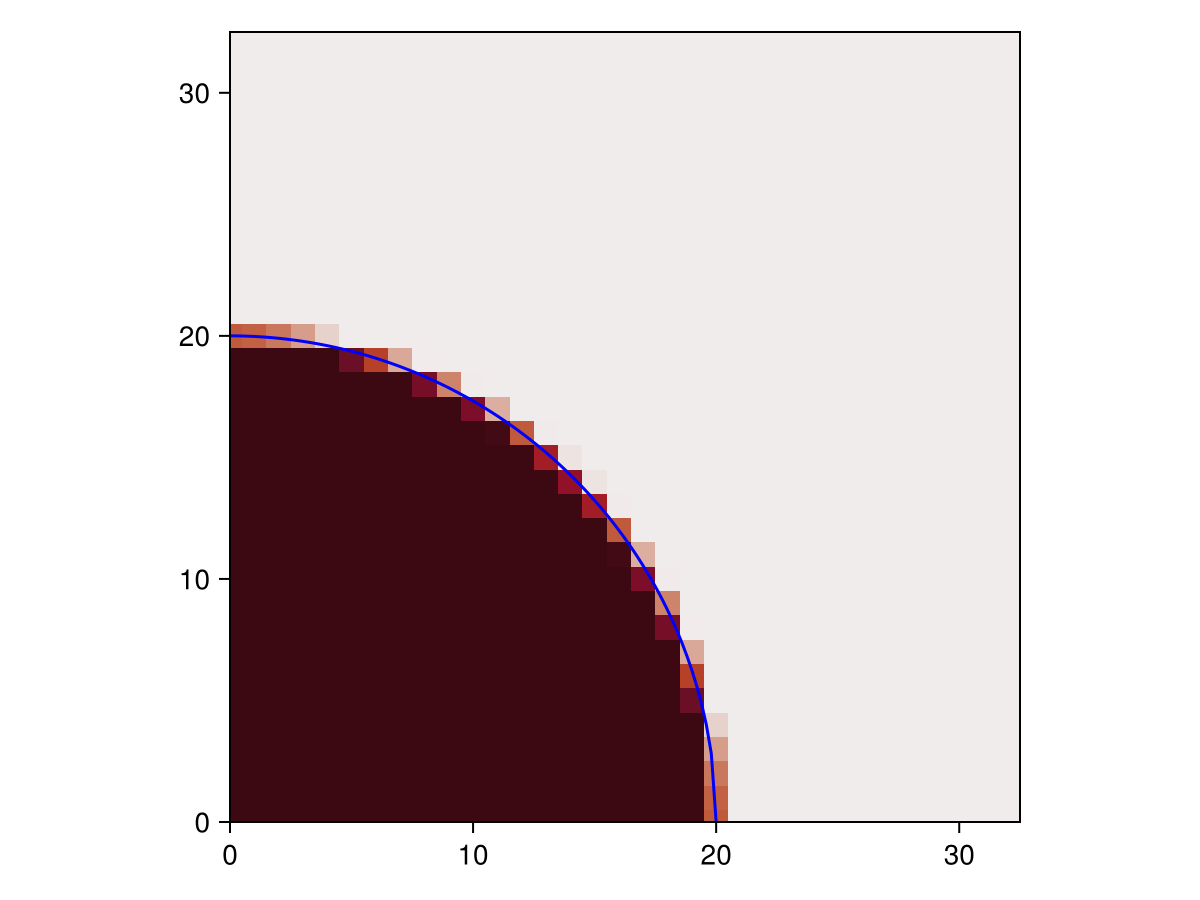

In [38]:
grid = TwoDGrid(nx=64, Lx=2π)
radius = 20
approx_weights = get_approximate_weights(grid, radius)
weights = get_weights(grid, radius)
fig = Figure()
ax = Axis(fig[1,1]; 
    #xticks = 1:grid.nkr, yticks = 1:grid.nkr, 
    #xminorticks = 0.5:grid.nkr, yminorticks = 0.5:grid.nkr,
    limits=((0, grid.nkr-0.5), (0, grid.nkr-0.5)),
    aspect = DataAspect(),
    xgridvisible = false,
    ygridvisible = false,
    xminorgridvisible = false,
    yminorgridvisible = false,
    xminorgridcolor = :black,
    yminorgridcolor = :black)

centers_x = grid.kr[:]
centers_y = grid.l[1:grid.nkr]
centers_y[grid.nkr] = -centers_y[grid.nkr]
println(size(centers_x))
hm = heatmap!(ax, centers_x, centers_y, weights, colormap=:balance, colorrange=(-1, 1))
translate!(hm, 0, 0, -100)
#scatter!(ax, [(x, y) for x in centers_x for y in centers_y], color=:white, strokecolor=:black, strokewidth=1)
x = 0.0:(radius/100):(radius)
y = sqrt.(radius^2 .- x.^2)
lines!(x, y, color="blue")

fig

(33,)
(64,)
(33, 64)


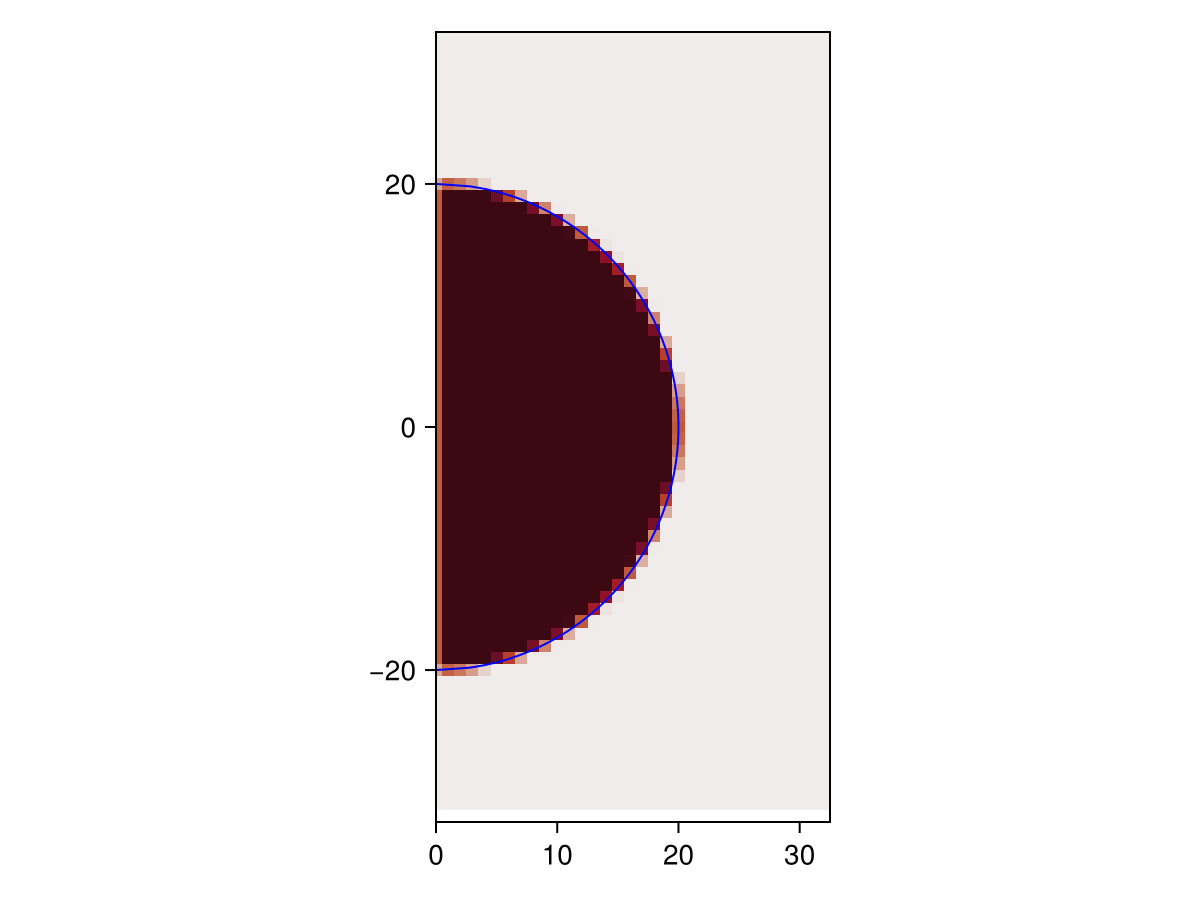

In [82]:
grid = TwoDGrid(nx=64, Lx=2π)
radius = 20
approx_weights = get_approximate_weights(grid, radius)
weights = get_weights(grid, radius)
duplicate_weights = hcat(weights[:, end-1:-1:2], weights)
duplicate_weights[2:end-1, :] *= 2
fig = Figure()
ax = Axis(fig[1,1]; 
    #xticks = 1:grid.nkr, yticks = 1:grid.nkr, 
    #xminorticks = 0.5:grid.nkr, yminorticks = 0.5:grid.nkr,
    limits=((0, grid.nkr-0.5), (-grid.nkr+0.5, grid.nkr-0.5)),
    aspect = DataAspect(),
    xgridvisible = false,
    ygridvisible = false,
    xminorgridvisible = false,
    yminorgridvisible = false,
    xminorgridcolor = :black,
    yminorgridcolor = :black)

centers_x = grid.kr[:]
centers_y = vcat(grid.l[grid.nkr+1:end], grid.l[1:grid.nkr])
centers_y[end] = -centers_y[end]
println(size(centers_x))
println(size(centers_y))
println(size(duplicate_weights))
hm = heatmap!(ax, centers_x, centers_y, duplicate_weights, colormap=:balance, colorrange=(-2, 2))
translate!(hm, 0, 0, -100)
#scatter!(ax, [(x, y) for x in centers_x for y in centers_y], color=:white, strokecolor=:black, strokewidth=1)
y = (-radius):(radius/100):(radius)
x = sqrt.(radius^2 .- y.^2)
lines!(x, y, color="blue", linewidth=1)

fig

In [39]:
println(size(centers_x))
println(size(centers_y))
println(size(weights))

(33,)
(33,)
(33, 33)


In [69]:
grid.l[grid.nkr+1:end]

31-element Vector{Float64}:
 -31.0
 -30.0
 -29.0
 -28.0
 -27.0
 -26.0
 -25.0
 -24.0
 -23.0
 -22.0
 -21.0
 -20.0
 -19.0
   ⋮
 -12.0
 -11.0
 -10.0
  -9.0
  -8.0
  -7.0
  -6.0
  -5.0
  -4.0
  -3.0
  -2.0
  -1.0

In [81]:
println(weights[:,grid.nkr-12])

[0.4979164713105583, 0.4728929860723795, 0.39763355311596016, 0.2715640260512708, 0.09406047505546916, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [270]:
k = grid.kr
    l = (grid.l[1:grid.nkr])'
    l[grid.nkr] = -grid.l[grid.nkr]
    Krsq = k.^2 .+ l.^2
    dk = k[2] - k[1]
    dk_half = dk/2
    
    W_k = k .- dk_half
    E_k = k .+ dk_half
    S_l = l .- dk_half
    N_l = l .+ dk_half
    
    S_l[1] = 0
    N_l[1] = dk_half
    W_k[1] = 0
    E_k[1] = dk_half

0.5

In [275]:
N_l

1×9 Matrix{Float64}:
 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5